<a href="https://colab.research.google.com/github/Iramuk-ganh/rl/blob/main/neural_network_for_function_approximation_and_qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys, os
if 'google.colab' in sys.modules:
    %tensorflow_version 1.x
    
    if not os.path.exists('.setup_complete'):
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week4_approx/submit.py

        !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

TensorFlow 1.x selected.
Selecting previously unselected package xvfb.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19.6-1ubuntu4.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
env = gym.make("CartPole-v0").env

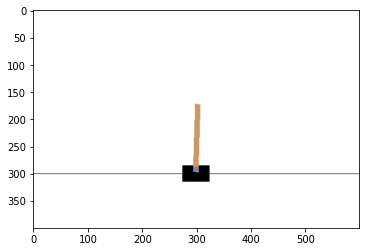

In [4]:
env.reset()
no_of_actions = env.action_space.n
obs_state_dim = env.observation_space.shape
plt.imshow(env.render("rgb_array"))

###Building neural network for action-value function approximation

In [5]:
import tensorflow as tf
import keras
import keras.layers as L

In [6]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

In [9]:
neural_network = keras.models.Sequential()
neural_network.add(L.InputLayer(obs_state_dim))
neural_network.add(L.Dense(200, activation='relu'))#relu is a non-saturating non-linearity
neural_network.add(L.Dense(100, activation='relu'))
neural_network.add(L.Dense(no_of_actions, activation = 'linear'))

😌np.random.rand() when no arguments passed returns a random decimal number between 0 and 1

In [12]:
np.random.rand()

0.28534617259920536

In [18]:
no_of_actions

2

In [19]:
np.random.choice(no_of_actions, 1)

array([0])

In [33]:
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    
    q_values = neural_network.predict(state[None])[0]#neural_network outputs action_value functions for a particular state and all actions
    #q_values is an array with q_value corresponding to each action i.e no. of elements in q_values = no_of_actions
    
    prob = np.random.rand()

    if prob < epsilon:
      action = np.random.choice(no_of_actions, 1)[0]

    else:
      action = np.argmax(q_values)

    return action

In [24]:
np.random.choice([0, 1], p=(0.1, 1-0.1))

1

In [30]:
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    
    q_values = neural_network.predict(state[None])[0]
    
    choice = np.random.choice([0, 1], p=(epsilon, 1-epsilon))

    if choice:#explore or take random actions
      action = np.random.choice(no_of_actions, 1)[0]

    else:#exploit or take the best action
      action = np.argmax(q_values)

    return action

In [34]:
assert neural_network.output_shape == (None, no_of_actions), "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert neural_network.layers[-1].activation == keras.activations.linear, "please make sure you predict q-values without nonlinearity"

# test epsilon-greedy exploration
s = env.reset()
assert np.shape(get_action(s)) == (), "please return just one action (integer)"
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount([get_action(s, epsilon=eps) for i in range(10000)], minlength=no_of_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] - 10000 * (1 - eps + eps / no_of_actions)) < 200
    for other_action in range(no_of_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] - 10000 * (eps / no_of_actions)) < 200
    print('e=%.1f tests passed'%eps)

e=0.0 tests passed
e=0.1 tests passed
e=0.5 tests passed
e=1.0 tests passed


###Q-learning via gradient descent

In [37]:
# Create placeholders for the <s, a, r, s'> tuple and a special indicator for game end (is_done = True)
states_ph = keras.backend.placeholder(dtype='float32', shape=(None,) + obs_state_dim)
actions_ph = keras.backend.placeholder(dtype='int32', shape=[None])
rewards_ph = keras.backend.placeholder(dtype='float32', shape=[None])
next_states_ph = keras.backend.placeholder(dtype='float32', shape=(None,) + obs_state_dim)
is_done_ph = keras.backend.placeholder(dtype='bool', shape=[None])

😌tf.one_hot()

indices = [0, 1, 2]
depth = 3
tf.one_hot(indices, depth) 
 output: [3 x 3]

 [[1., 0., 0.],

  [0., 1., 0.],

  [0., 0., 1.]]

😌tf.reduce_sum()

x = tf.constant([[1, 1, 1], [1, 1, 1]])

tf.reduce_sum(x)  # 6

tf.reduce_sum(x, 0)  # [2, 2, 2]

tf.reduce_sum(x, 1)  # [3, 3]

In [40]:
#get q-values for all actions in current states
predicted_qvalues = neural_network(states_ph)

#select q-values for chosen actions
predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot(actions_ph, no_of_actions), axis = 1)

In [43]:
gamma = 0.99

# compute q-values for all actions in next states
predicted_next_qvalues = neural_network(next_states_ph)

# compute V*(next_states) using predicted next q-values
next_state_values = tf.reduce_max(predicted_next_qvalues, axis = 1)#max_qvalue for the next state over all possible actions

# compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
target_qvalues_for_actions = rewards_ph + gamma * next_state_values

# at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
target_qvalues_for_actions = tf.where(is_done_ph, rewards_ph, target_qvalues_for_actions)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [44]:
#mean squared error loss to minimize
loss = (predicted_qvalues_for_actions - tf.stop_gradient(target_qvalues_for_actions)) ** 2
loss = tf.reduce_mean(loss)

# training function that resembles agent.update(state, action, reward, next_state) from tabular agent
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [45]:
assert tf.gradients(loss, [predicted_qvalues_for_actions])[0] is not None, "make sure you update q-values for chosen actions and not just all actions"
assert tf.gradients(loss, [predicted_next_qvalues])[0] is None, "make sure you don't propagate gradient w.r.t. Q_(s',a')"
assert predicted_next_qvalues.shape.ndims == 2, "make sure you predicted q-values for all actions in next state"
assert next_state_values.shape.ndims == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
assert target_qvalues_for_actions.shape.ndims == 1, "there's something wrong with target q-values, they must be a vector"

###Playing the game

❓sess.run()

In [46]:
sess.run(tf.global_variables_initializer())

In [47]:
def generate_session(env, t_max = 1000, epsilon = 0, train = False):
  total_reward = 0
  s = env.reset()

  for t in range(t_max):
    a = get_action(s, epsilon=epsilon)
    next_s, r, done, _ = env.step(a)

    if train:
      sess.run(train_step,
               {
                states_ph: [s], 
                actions_ph: [a],
                rewards_ph: [r],
                next_states_ph: [next_s],
                is_done_ph: [done]
               })
      
      total_reward += r
      s = next_s
      if done:
        break
  return total_reward

In [48]:
epsilon = 0.5

In [50]:
for i in range(1000):
  session_rewards = [generate_session(env, epsilon=epsilon, train=True) for _ in range(100)]
  print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))
    
  epsilon *= 0.99
  assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"
  
  if np.mean(session_rewards) > 300:
      print("You Win!")
      break

epoch #0	mean reward = 16.080	epsilon = 0.500
epoch #1	mean reward = 14.620	epsilon = 0.495
epoch #2	mean reward = 17.770	epsilon = 0.490
epoch #3	mean reward = 14.840	epsilon = 0.485
epoch #4	mean reward = 15.780	epsilon = 0.480
epoch #5	mean reward = 15.690	epsilon = 0.475
epoch #6	mean reward = 15.670	epsilon = 0.471
epoch #7	mean reward = 34.870	epsilon = 0.466
epoch #8	mean reward = 32.070	epsilon = 0.461
epoch #9	mean reward = 36.040	epsilon = 0.457
epoch #10	mean reward = 43.300	epsilon = 0.452
epoch #11	mean reward = 58.180	epsilon = 0.448
epoch #12	mean reward = 66.470	epsilon = 0.443
epoch #13	mean reward = 107.610	epsilon = 0.439
epoch #14	mean reward = 124.850	epsilon = 0.434
epoch #15	mean reward = 138.640	epsilon = 0.430
epoch #16	mean reward = 157.890	epsilon = 0.426
epoch #17	mean reward = 164.270	epsilon = 0.421
epoch #18	mean reward = 188.410	epsilon = 0.417
epoch #19	mean reward = 205.360	epsilon = 0.413
epoch #20	mean reward = 197.640	epsilon = 0.409
epoch #21	mean 